In [1]:
import pandas as pd
from tqdm import tqdm
import os
from torch.utils.data import Dataset, DataLoader
import cv2

import torch
from torchvision import  models

seed = 42
torch.manual_seed(seed)

In [2]:
labels = ['belly dancing', 'breakdancing', 'country line dancing',
       'dancing ballet', 'dancing charleston', 'dancing gangnam style',
       'dancing macarena', 'jumpstyle dancing', 'mosh pit dancing',
       'robot dancing', 'salsa dancing', 'square dancing',
       'swing dancing', 'tango dancing', 'tap dancing']
label_mapping = {x : idx for idx, x in enumerate(labels)}


In [4]:
class VideoDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the videos.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.annotations = pd.read_csv(csv_file, index_col=False)
        self.annotations = self.annotations.sample(len(self.annotations) // 4) # уменьшаю датасет в 4 раза, а то долго
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        video_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        class_label = self.annotations.iloc[idx, 1]
        return video_path, class_label #frames, class_label



In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = VideoDataset(csv_file='/kaggle/input/dance-videos/train_annotations.csv', root_dir='/kaggle/input/dance-videos/videos', transform=transform)
test_dataset = VideoDataset(csv_file='/kaggle/input/dance-videos/test_annotations.csv', root_dir='/kaggle/input/dance-videos/videos', transform=transform)
val_dataset = VideoDataset(csv_file='/kaggle/input/dance-videos/val_annotations.csv', root_dir='/kaggle/input/dance-videos/videos', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=12, shuffle=False)


In [6]:
num_classes = 15

# Load the pretrained ResNet model
model = models.resnet50(pretrained=True)

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer for fine-tuning
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 5
each_n_frame = 10

## Train

In [8]:
accuracy_train = []
accuracy_val = []
losses_train = []
losses_val = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for video_paths, labels in tqdm(train_loader):
        outputs = torch.tensor(()).to(device)
        for video_path in video_paths:
            cap = cv2.VideoCapture(video_path)
            # cap.set(cv2.CAP_PROP_POS_FRAMES, each_n_frame)
            video_output = []
            i = 0
            while True:
                ret, frame = cap.read()
                if i % each_n_frame:
                    if not ret:
                        break
                    frame = transform(frame)
                    frame = frame.to(device)
                    frame = frame.unsqueeze(0) # or batch of frames
                    video_output.append(model(frame))
                i += 1
            cap.release()
            output = torch.mean(torch.stack(video_output), dim=0)
            outputs = torch.cat((outputs, output), dim=0)

        labels = labels.to(device)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    loss_train = running_loss / len(train_loader)
    losses_train.append(loss_train)
    accuracy = 100 * correct / total
    accuracy_train.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_train:.4f}, Accuracy: {accuracy:.2f}%')


    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for video_paths, labels in tqdm(val_loader):
            outputs = torch.tensor(()).to(device)
            for video_path in video_paths:
                cap = cv2.VideoCapture(video_path)
                # cap.set(cv2.CAP_PROP_POS_FRAMES, each_n_frame)
                video_output = []
                i = 0
                while True:
                    ret, frame = cap.read()
                    if i % each_n_frame:
                        if not ret:
                            break
                        frame = transform(frame)
                        frame = frame.to(device)
                        frame = frame.unsqueeze(0) # or batch of frames
                        video_output.append(model(frame))
                    i += 1
                cap.release()
                output = torch.mean(torch.stack(video_output), dim=0)
                outputs = torch.cat((outputs, output), dim=0)

            labels = labels.to(device)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss_val = val_running_loss / len(val_loader)
    losses_val.append(loss_val)
    accuracy = 100 * correct / total
    accuracy_val.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {loss_val:.4f}, Accuracy: {accuracy:.2f}%')

  1%|          | 1/109 [00:30<54:33, 30.31s/it][h264 @ 0x5becbb6adb80] mmco: unref short failure
[h264 @ 0x5becbb6adb80] mmco: unref short failure
 17%|█▋        | 19/109 [09:53<47:42, 31.81s/it][h264 @ 0x5becb9551500] mmco: unref short failure
[h264 @ 0x5becb9551500] mmco: unref short failure
100%|██████████| 109/109 [55:54<00:00, 30.78s/it]


Epoch [1/5], Loss: 2.7842, Accuracy: 7.28%


100%|██████████| 24/24 [09:49<00:00, 24.54s/it]


Epoch [1/5], Validation Loss: 0.0000, Accuracy: 5.73%


 15%|█▍        | 16/109 [08:09<46:08, 29.76s/it][h264 @ 0x5becb8d48000] mmco: unref short failure
[h264 @ 0x5becb8d48000] mmco: unref short failure
 41%|████▏     | 45/109 [23:30<35:34, 33.35s/it][h264 @ 0x5becb8ae9840] mmco: unref short failure
[h264 @ 0x5becb8ae9840] mmco: unref short failure
100%|██████████| 109/109 [57:06<00:00, 31.44s/it]


Epoch [2/5], Loss: 2.7881, Accuracy: 7.13%


100%|██████████| 24/24 [09:45<00:00, 24.40s/it]


Epoch [2/5], Validation Loss: 0.0000, Accuracy: 3.58%


  7%|▋         | 8/109 [04:08<51:19, 30.49s/it][h264 @ 0x5becbae042c0] mmco: unref short failure
[h264 @ 0x5becbae042c0] mmco: unref short failure
 31%|███       | 34/109 [17:37<36:55, 29.54s/it][h264 @ 0x5becba59c980] mmco: unref short failure
[h264 @ 0x5becba59c980] mmco: unref short failure
100%|██████████| 109/109 [56:09<00:00, 30.92s/it]


Epoch [3/5], Loss: 2.7894, Accuracy: 8.35%


100%|██████████| 24/24 [09:59<00:00, 24.99s/it]


Epoch [3/5], Validation Loss: 0.0000, Accuracy: 5.73%


 71%|███████   | 77/109 [40:12<15:21, 28.81s/it][h264 @ 0x5becb865a340] mmco: unref short failure
[h264 @ 0x5becb865a340] mmco: unref short failure
 84%|████████▍ | 92/109 [48:04<08:53, 31.36s/it][h264 @ 0x5becb9461b00] mmco: unref short failure
[h264 @ 0x5becb9461b00] mmco: unref short failure
100%|██████████| 109/109 [56:38<00:00, 31.17s/it]


Epoch [4/5], Loss: 2.8005, Accuracy: 6.67%


100%|██████████| 24/24 [09:50<00:00, 24.60s/it]


Epoch [4/5], Validation Loss: 0.0000, Accuracy: 10.04%


 13%|█▎        | 14/109 [07:20<49:18, 31.14s/it][h264 @ 0x5becb86cc180] mmco: unref short failure
[h264 @ 0x5becb86cc180] mmco: unref short failure
 56%|█████▌    | 61/109 [31:51<24:30, 30.63s/it][h264 @ 0x5becb931ecc0] mmco: unref short failure
[h264 @ 0x5becb931ecc0] mmco: unref short failure
100%|██████████| 109/109 [56:22<00:00, 31.03s/it]


Epoch [5/5], Loss: 2.7899, Accuracy: 5.98%


100%|██████████| 24/24 [09:40<00:00, 24.17s/it]

Epoch [5/5], Validation Loss: 0.0000, Accuracy: 4.66%


## Plots

In [9]:
import matplotlib.pyplot as plt

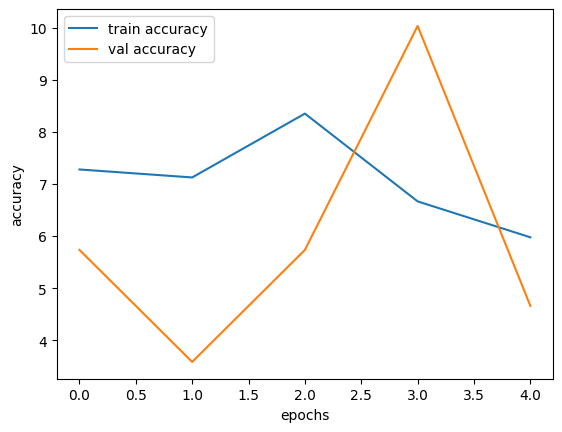

In [10]:
plt.plot(accuracy_train, label = 'train accuracy')
plt.plot(accuracy_val, label = 'val accuracy')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

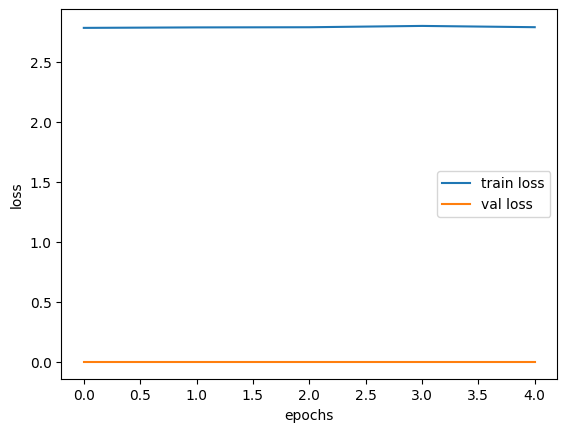

In [11]:
plt.plot(losses_train, label = 'train loss')
plt.plot(losses_val, label = 'val loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()